# Condensation flux

In this notebook, I compare the condensation flux obtained from experiment with the model in [Jung 2021](https://pubs.acs.org/doi/10.1021/acs.langmuir.1c00473).

## 0 Packages

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams["font.family"] = "STIXGeneral"
matplotlib.rcParams["mathtext.fontset"] = "stix"
matplotlib.rcParams["xtick.direction"] = "in"
matplotlib.rcParams["ytick.direction"] = "in"
plt.rcParams['xtick.major.size'] = 2  # Length of major ticks
plt.rcParams['ytick.major.size'] = 2  # Length of major ticks
plt.rcParams['xtick.minor.size'] = 1  # Length of minor ticks
plt.rcParams['ytick.minor.size'] = 1  # Length of minor ticks
import cv2
import shutil
from myimagelib.myImageLib import readdata
import pandas as pd

## 1 Theory: single semi-sphere and semi-cylinder

The model predicts the condensation flux near a bump on a flat surface. The condensation on the bump is currently inaccessible from experiment, so we focus on the flux outside the bump on the flat surface. 

Near a semi-spherical bump, the flux outside the bump is modeled as

$$
J_{cylinder} = 1 - \frac{r^3}{x^3},
$$

where $x$ is the distance from the fungal patch center and $r$ is the radius of the fungal patch. 

Note that the fluxes are all relative to the flux in a canonical case where condensation happens on a pure flat surface. 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


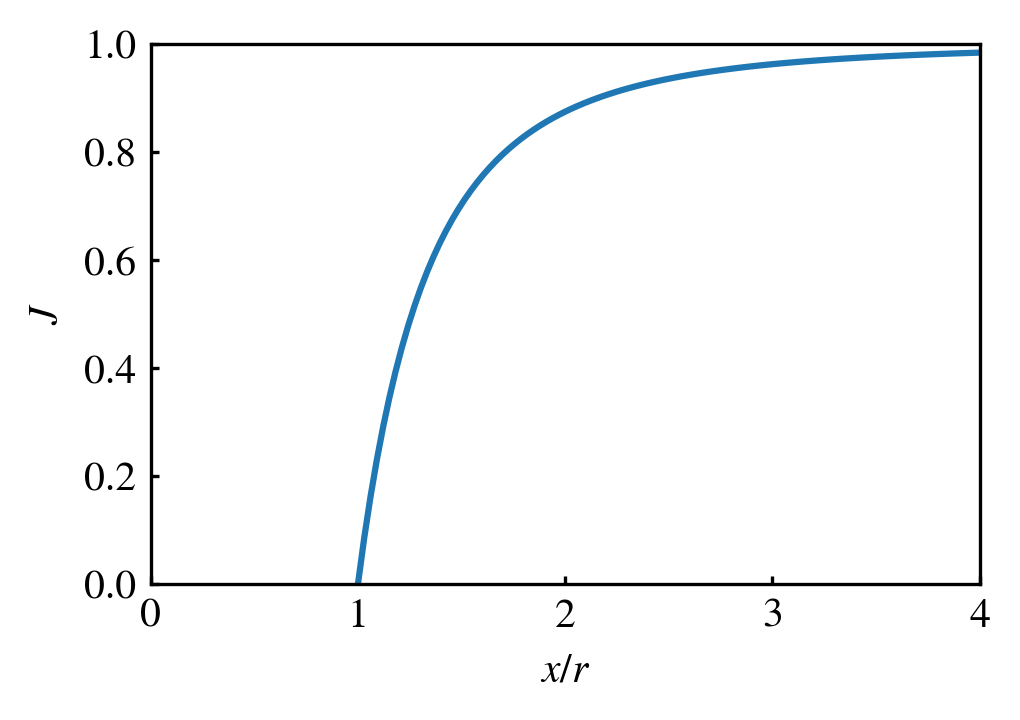

In [6]:
r = 1 # radius of the circle
x = np.linspace(r, 4*r, 100)
J = 1 - r**3 / x**3

fig, ax = plt.subplots(figsize=(3.5, 2.5), dpi=300)
ax.plot(x, J)

ax.set_xlabel("$x/r$")
ax.set_ylabel("$J$")
ax.legend(frameon=False)
ax.set_xlim(0, 4*r)
ax.set_ylim(0, 1)
plt.tight_layout()
plt.savefig("flux_around_a_bump.pdf")

## 2 Experiment: droplet detection

Cole has worked on detecting droplets over the summer. The work has mainly been on the video `exp5.avi` on `06282024`. Here, I use the hand labeling data to improve the data quality.

The starting point of all the calculations should be the raw droplet detection, in the form of .csv files with columns [x, y, r]. Calibration and frame rate are needed to convert the data from experiment units (px, frame) to physical units (mm, min). 

Here, I propose the data folder structure as the following:

```
date\
    tracking\
        exp1\ (video file name)
            0000.csv (xyr data)
            0001.csv
            ...
            fps_mpp.txt (calibration information)
    exp1.avi
```

Always read raw data and make plots. 

In [48]:
# function to exrtract frames from a video file
def get_frame_from_video(video_path, frame_number):
    cap = cv2.VideoCapture(video_path)
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
    ret, frame = cap.read()
    cap.release()
    if not ret:
        raise ValueError(f"Could not read frame {frame_number}")
    return frame

### 2.1 Generate drop detection overlay

In [124]:
#### set parameters ####
folder = r"E:\F\09252024"
filename = "exp2"
fns = range(6600, 36000, 1000)
########################

for frame_number in fns:
    video_path = os.path.join(folder, filename+".MOV")
    data_path = os.path.join(folder, "tracking", filename, "blob", f"{frame_number:05d}.csv")
    frame = get_frame_from_video(video_path, frame_number)
    h, w = frame.shape[:2]
    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    drops = pd.read_csv(data_path)

    #prepare results
    overlay_frame = rgb_frame.copy()
    for i, drop in drops.iterrows():
        x, y, r = drop[["x", "y", "r"]].astype(int)
        cv2.circle(overlay_frame, (x, y), r, (255, 255, 0), 3)

    # save overlay image
    dpi = 600
    plt.figure(figsize=(w/dpi,h/dpi), dpi=dpi)
    plt.imshow(overlay_frame)
    plt.axis("off")
    plt.savefig(os.path.join(folder, "tracking", filename, f"{frame_number:05d}.jpg"), bbox_inches="tight", pad_inches=0)
    plt.close()

### 2.2 Drop number, mean size and flux

Plot total droplet number and mean radius of droplets over time.

(0.0, 20.0)

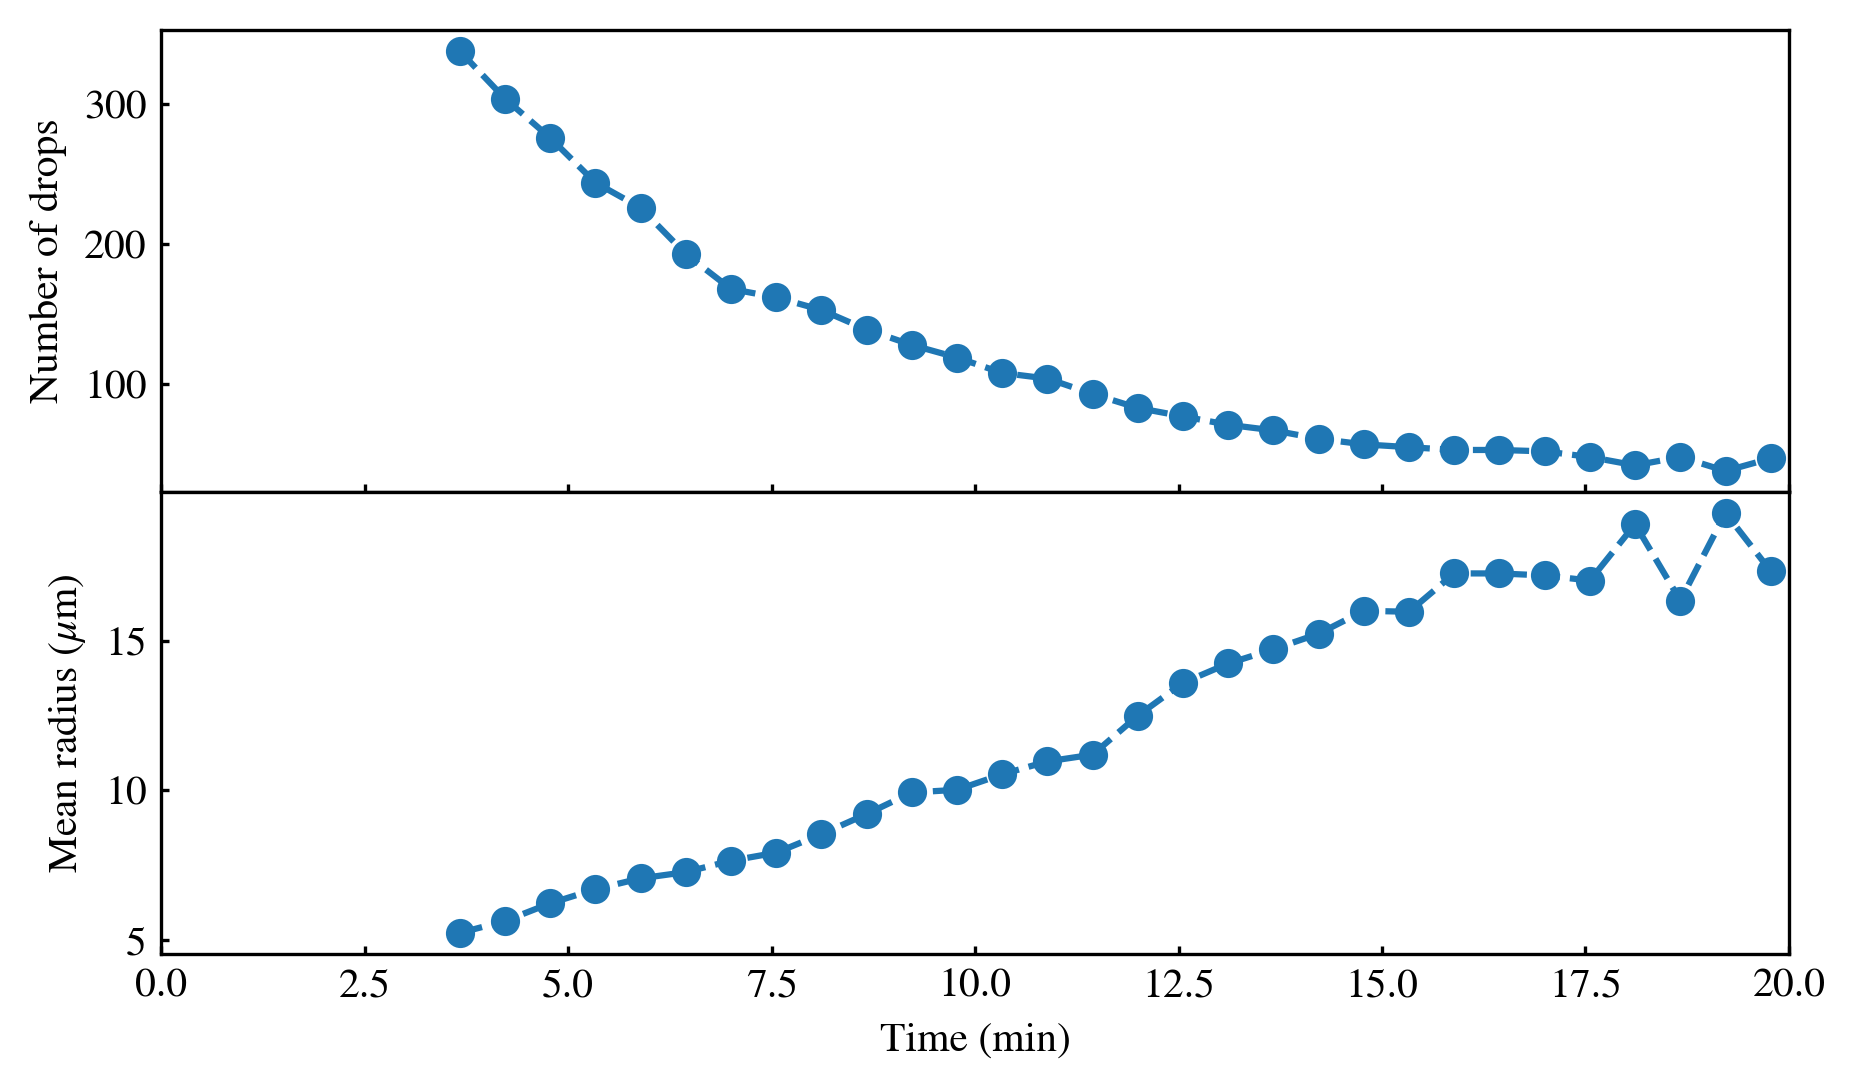

In [136]:
folder = r"E:\F\09252024\tracking\exp2"
l = readdata(os.path.join(folder, "blob"), "csv")
# read calibration data
with open(os.path.join(folder, "fps_mpp.txt"), "r") as f:
    fps = float(f.readline().strip().split(":")[1])
    mpp = float(f.readline().strip().split(":")[1])
    x0, y0, r0 = [int(i) for i in f.readline().strip().split(":")[1].split(",")]

# read data and obtain total drops and mean radius
total_drops = []
mean_size = []
t = []
for num, i in l.iterrows():
    xyr = pd.read_csv(i.Dir)
    total_drops.append(len(xyr))
    mean_size.append(xyr.r.mean()*mpp)
    t.append(float(i.Name)/fps)
    # convert to polar coordinates
    xyr["R"] = ((xyr.x - x0)**2 + (xyr.y - y0)**2) ** 0.5

# plot the results
fig, ax = plt.subplots(nrows=2, figsize=(7, 4), dpi=300, sharex=True, gridspec_kw={"hspace": 0})
ax[0].plot(np.array(t)/60, total_drops, ls="--", marker="o")
ax[0].set_ylabel("Number of drops")
ax[1].plot(np.array(t)/60, mean_size, ls="--", marker="o")
ax[1].set_ylabel("Mean radius ($\mu$m)")
ax[1].set_xlabel("Time (min)")
ax[1].set_xlim(0, 20)

Plot the droplet total volume vs. time in distance bins.

In [118]:
# set up the parameters
folder = r"E:\F\09252024\tracking\exp2"
bins = np.linspace(r0, 1.3*r0, 6)

l = readdata(os.path.join(folder, "blob"), "csv")
# read calibration data
with open(os.path.join(folder, "fps_mpp.txt")) as f:
    fps = float(f.readline().strip().split(":")[1])
    mpp = float(f.readline().strip().split(":")[1])
    x0, y0, r0 = [int(i) for i in f.readline().strip().split(":")[1].split(",")]

# create data to store total volume in a band at each time
data = {}
for num, i in l.iterrows():
    xyr = pd.read_csv(i.Dir)
    xyr["R"] = ((xyr.x - x0)**2 + (xyr.y - y0)**2) ** 0.5
    data[i.Name] = []
    for j in range(len(bins)-1):
        sub_xyr = xyr[(xyr.R >= bins[j]) & (xyr.R < bins[j+1])]
        data[i.Name].append(((sub_xyr.r*mpp*1e-3)**3 * np.pi * 2/3).sum())

# convert dict to dataframe, leave the index as default 
df = pd.DataFrame(data, columns=l.Name)

# compute the area of 

In [119]:
# compute flux from volume
dr = (bins[1] - bins[0]) * mpp * 1e-3
dt = 5 / fps / 60

flux = pd.DataFrame()
for kw in df.T:
    # area = 2 * np.pi * (kw*r0*mpp*1e-3) * dr
    area = 1080 * mpp * 1e-3 * dr
    flux[kw] = (df.T[kw].diff() / area / dt)

In [120]:
flux = flux.T

C:\Users\zl948\AppData\Local\Temp\ipykernel_185924\4161854116.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("winter")


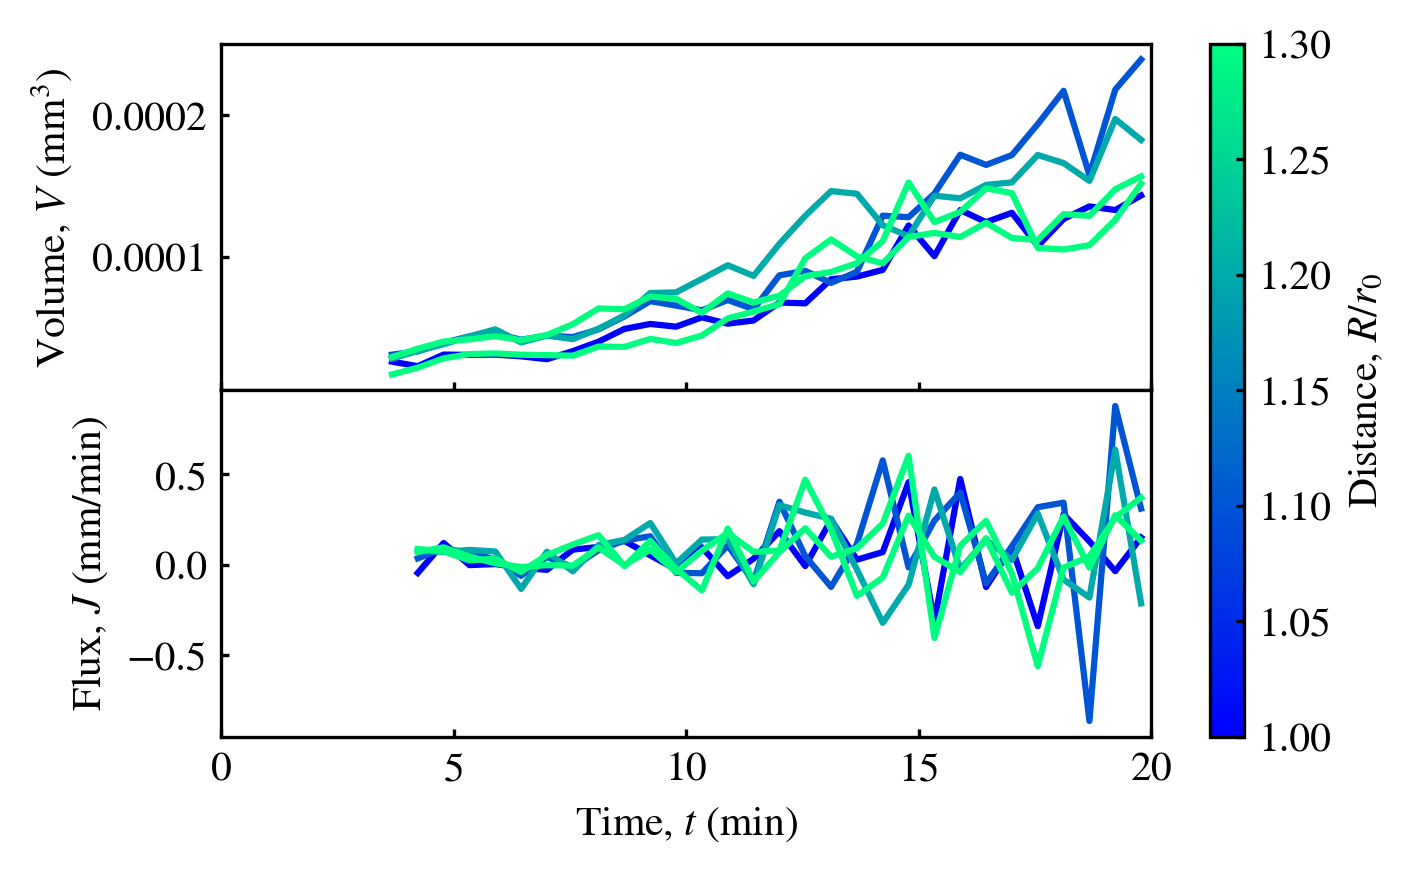

In [121]:
fig, ax = plt.subplots(nrows=2, figsize=(5, 3), dpi=300, sharex=True, gridspec_kw={"hspace": 0})
cmap = plt.cm.get_cmap("winter")
for kw in df.T:
    t = df.T.index.astype(float)/fps/60 # in min
    ax[0].plot(t, df.T[kw], color=cmap(kw/3), label=f"${kw:.1f}$")
    ax[1].plot(t, flux.T[kw], color=cmap(kw/3), label=f"${kw:.1f}$")
# ax.legend(frameon=False, title="Distance ($r_0$)")
# generate a colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(1, 1.3))
sm.set_array([])
plt.colorbar(sm, ax=ax, label="Distance, $R/r_0$")
# plt.colorbar(sm, ax=ax[1], label="Distance, $R/r_0$")
ax[0].set_xlim([0, 20])
# ax[0].set_ylim([0, 0.35])
ax[1].set_xlabel("Time, $t$ (min)")
ax[0].set_ylabel("Volume, $V$ (mm$^3$)")
ax[1].set_ylabel("Flux, $J$ (mm/min)")
# plt.tight_layout()
fig.savefig("volume_vs_time.pdf")

In [122]:
kw

4

C:\Users\zl948\AppData\Local\Temp\ipykernel_185924\3462871505.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("viridis")


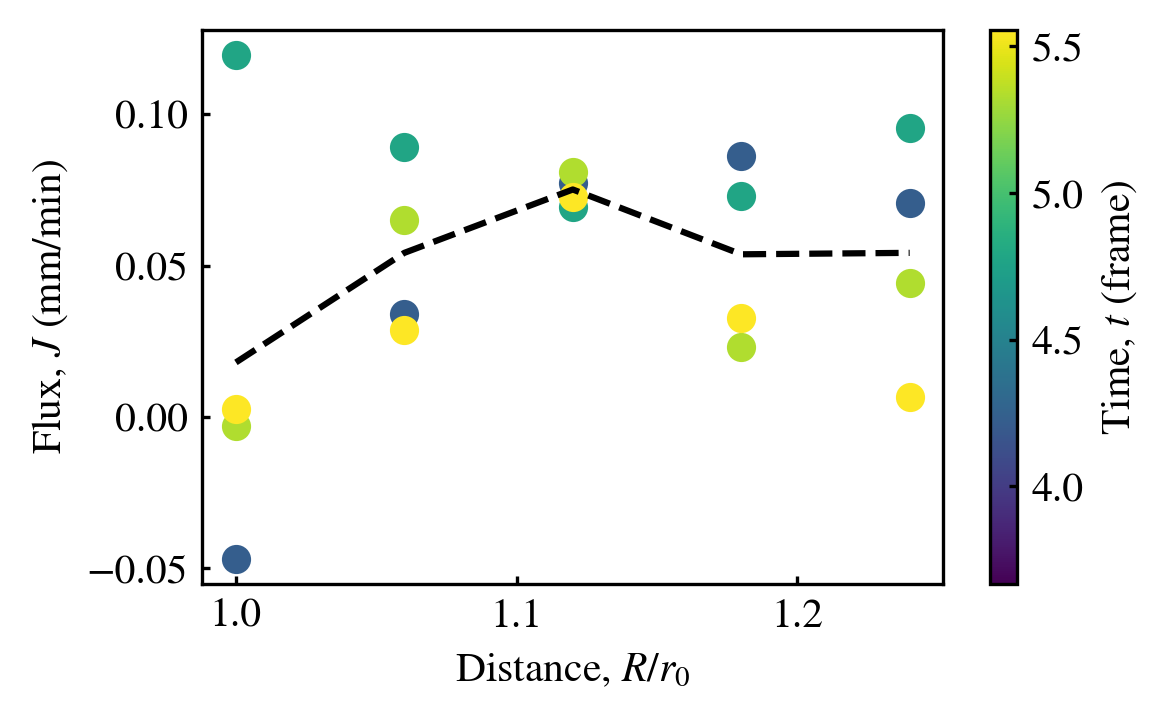

In [129]:
# plot flux as a function of distance
fig, ax = plt.subplots(figsize=(4, 2.5), dpi=300)
cmap = plt.cm.get_cmap("viridis")
sum_flux = 0
count = 0
for kw in flux.dropna(axis=1):
    ax.plot(bins[:-1]/r0, flux[kw], color=cmap((float(kw)-6600)/3400), label=f"${float(kw)/fps/60}$", ls="", marker="o")
    sum_flux += flux[kw]
    count += 1
    if float(kw) > 10000:
        break

ax.plot(bins[:-1]/r0, sum_flux/count, color="black", label="Average", ls="--")
ax.set_xlabel("Distance, $R/r_0$")
ax.set_ylabel("Flux, $J$ (mm/min)")
# ax.set_xlim([0, 3])
# ax.legend(frameon=False, title="Distance ($r_0$)")
# generate a colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(6600/fps/60, 10000/fps/60))
sm.set_array([])
plt.colorbar(sm, ax=ax, label="Time, $t$ (frame)")
# ax.set_xlim([0, 3])
plt.tight_layout()
fig.savefig("flux_vs_distance.pdf")

In [134]:
6600/30/60

3.6666666666666665

In [135]:
7600/30/60

4.222222222222222

## Appendix A. Extract hand labeling data

In [43]:
# I have a folder, in which there are subfolders containing images, detection and information text files
# I want to read the information text files and save the frame number information to a list

folder = r"G:\My Drive\Research projects\F\Data\hand_labeling_data"
save_folder = r"G:\My Drive\Research projects\F\Data\06282024\tracking"
tar_date = "062824"
tar_title = "exp5.mp4"

os.makedirs(save_folder, exist_ok=True)
sfL = next(os.walk(folder))[1]

frame_list = []
for sf in sfL: 
    data_path = os.path.join(folder, sf, "info.txt")
    with open(data_path, "r") as f:
        lines = f.readlines()
        date = lines[0].strip().split(":")[-1].strip()
        title = lines[1].strip().split(":")[-1].strip()
        if date == tar_date and title == tar_title:
            frame_number = int(lines[2].strip().split(":")[-1])
            prelim_file = os.path.join(folder, sf, "prelim_detection.csv")
            hand_file = os.path.join(folder, sf, "hand.csv")
            if os.path.exists(hand_file):
                shutil.copy(hand_file, os.path.join(save_folder, f"{frame_number:04d}.csv"))
            else:
                shutil.copy(prelim_file, os.path.join(save_folder, f"{frame_number:04d}.csv"))

## Appendix B. Total volume decreases during condensation



## Appendix C. Illustrate droplet growth

(-5.5, 5.5, -0.24996853191846877, 5.249339170287843)

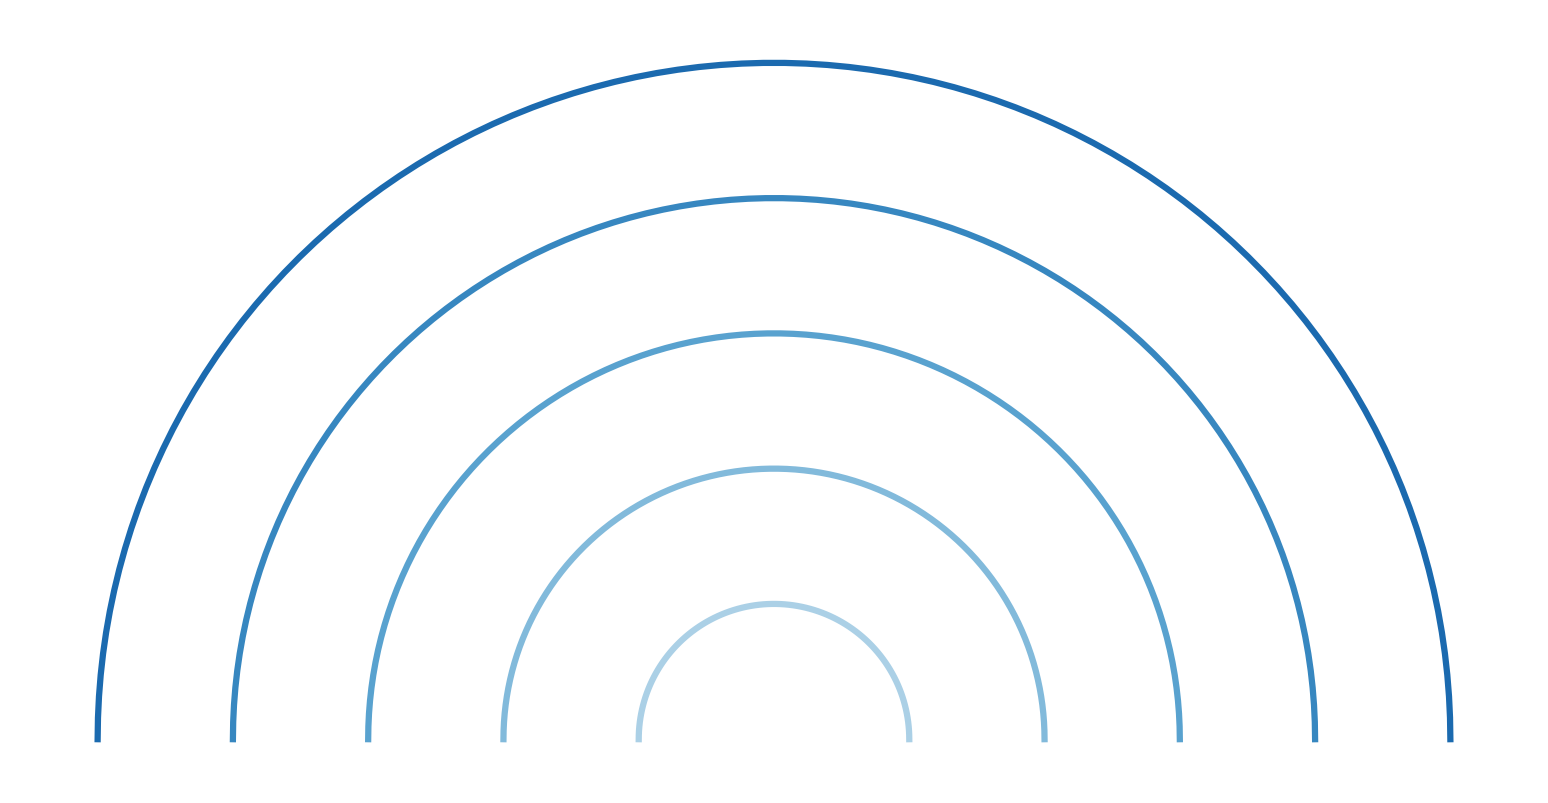

In [ ]:
# draw a few concentric hemisphere with different radii, color them using viridis colormap

def create_semicircle(radius, num_points=100):
    theta = np.linspace(0, np.pi, num_points)
    x = radius * np.cos(theta)
    y = radius * np.sin(theta)
    return x, y

# Step 3: Generate multiple semicircles with different radii
radii = [1, 2, 3, 4, 5]
colors = plt.get_cmap("Blues", 10)

# Step 4: Use the Viridis colormap to color the semicircles
fig, ax = plt.subplots(dpi=300)
i = 3
for radius in radii:
    x, y = create_semicircle(radius)
    ax.plot(x, y, color=colors(i))
    i += 1

# Step 5: Plot the semicircles using matplotlib
ax.set_aspect('equal')
ax.axis('off')

# generate colorbar

